In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

train = list()
test = list()

for i in range(10):
    train.append(np.array(pd.read_csv('Part3_%d_Train.csv'%i, header=None)))
    test.append(np.array(pd.read_csv('Part3_%d_Test.csv'%i, header=None)))

np.random.seed(21)
X_train = np.vstack(train)
y_train = np.concatenate([np.tile(i, train[i].shape[0]) for i in range(10)])
idx_train = np.array(range(X_train.shape[0]))
np.random.shuffle(idx_train)
X_train = X_train[idx_train]
y_train = y_train[idx_train]

X_test = np.vstack(test)
y_test = np.concatenate([np.tile(i, test[i].shape[0]) for i in range(10)])
idx_test = np.array(range(X_test.shape[0]))
np.random.shuffle(idx_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

enc = np.eye(2)
def one_hot(d):
    return enc[d]

print(X_train.shape, X_test.shape)

(5000, 784) (5000, 784)


In [2]:
from skimage.util import view_as_windows, view_as_blocks
W_conv = np.zeros((16, (7+21)*7+1))
W_out = np.empty((10, 22*22*16+1))

class seeded_session:
    def __enter__(self):
        np.random.seed(25523)
        global W_conv, W_out
        padded_weights = W_conv[:, :-1].reshape((-1, 7, 28))
        padded_weights[:, :, :7] = np.random.rand(16, 7, 7)*1e-5
        padded_weights[:, :, 7:] = 0.0
        W_conv[:, -1:] = np.random.rand(16, 1)*1e-5
        W_out[:] = np.random.rand(*W_out.shape)
        return W_conv, W_out
    def __exit__(self, type, value, traceback):
        pass

with seeded_session():
    print(W_conv.shape, W_out.shape)

(16, 197) (10, 7745)


In [3]:
A = np.zeros((5,5))
from skimage.util import view_as_windows, view_as_blocks
view_as_windows(A, (2,2)).shape

(4, 4, 2, 2)

In [4]:
np.zeros(0)

array([], dtype=float64)

# Forward pass

In [5]:
aa = np.array([0, 1])
bb = np.block([aa, aa])
bb[-1] = 2
aa

array([0, 1])

[ 0.08167216  0.06723635  0.06784451  0.12499845  0.10929     0.10653567
  0.13443319  0.13235481  0.06826789  0.10736697] 6
[ 0.08157977  0.06735625  0.06782699  0.12476304  0.10946821  0.10648655
  0.13444601  0.1322562   0.06827485  0.10754213] 0


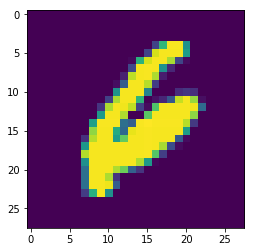

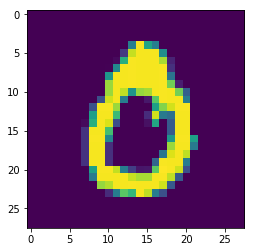

In [34]:
import itertools
from scipy.signal import convolve2d

CONV7_OFFSETS = list(itertools.chain(*[range(ii*28,ii*28+22) for ii in range(22)]))

def conv7(w):
    """ 7x7 convolution in matrix form """
    def forward1(x):
        convmat = np.block([
            #                 vvv throw away final padding & bias
            [np.zeros(jj), w[:-(21+1)], np.zeros(28*28-(7*28-21)-jj)]
                #   vvv starting position of the kernel
                for jj in CONV7_OFFSETS
        ])
        return np.tanh(np.dot(convmat, x) + w[-1])
    def forward2(x):
        row = []
        for ii in range(22):
            convmat = np.block([
                #                 vvv throw away final padding & bias
                [np.zeros(jj), w[:-(21+1)], np.zeros(28*28-(7*28-21)-jj)]
                    #   vvv starting position of the kernel
                    for jj in range(ii*28,ii*28+22)
            ])
            row.extend(np.dot(convmat, x))
        return np.tanh(np.array(row) + w[-1])
    def forward3(x):
        convmat = np.block([
            #                 vvv throw away final padding & bias
            [np.zeros(jj), w[:-(21+1)], np.zeros(21-jj)]
                #   vvv starting position of the kernel
                for jj in range(22)
        ])
        row = np.array([np.dot(convmat, x[ii*28:ii*28+7*28]) for ii in range(22)])
        return np.tanh(row + w[-1])
    # === above impls are correct, but to accelerate, I use forward0 ===
    def forward0(x):
        return np.tanh(convolve2d(
            x.reshape(28, 28),
            w[:-1].reshape((7, 28))[:, :7],
            mode='valid').ravel() + w[-1])
    return forward3

def softmax(x):
    a = np.exp(x)
    return a / np.sum(a)

def perceptron(w):
    return lambda x: np.dot(w[:-1], x) + w[-1]

conv_filters = [conv7(w) for w in W_conv]
conv_layer = lambda x: np.array([f(x) for f in conv_filters])
output_neurons = [perceptron(w) for w in W_out]
fc_layer = lambda x: softmax([f(x.ravel()) for f in output_neurons])
model = lambda x: fc_layer(conv_layer(x))

with seeded_session():
    for k in range(2):
        plt.figure()
        plt.imshow(X_train[k].reshape(28, 28).T)
        print(model(X_train[k]), y_train[k])

# Backward pass

Assuming loss function: $ \text{loss}(\mathbf{y}) = -\sum_j { d_j \log y_j } $

**Output layer**

$$
\delta_j^H = \frac{\partial E}{\partial \nu_j^H} = -e_j
$$

$$
\Delta w_{ij}^H = -\alpha \delta_j^H y_i^{H-1}
$$

$$
\Delta b_j^H = -\alpha \delta_j^H
$$

**Hidden layer**

$$
\delta_j^h = \frac{\partial E}{\partial \nu_j^h} = \left( \sum_{l = 1}^{L^{h+1}} \frac{\partial E}{\partial \nu_l^{h+1}} \frac{\partial \nu_l^{h+1}}{\partial y_j^h} \right) \frac{\partial y_j^h}{\partial \nu_j^h}
=\left( \sum_{l = 1}^{L^{h+1}} {\delta_l^H w_{jl}^H} \right) (1-(y_j^h)^2)
$$

$$
\Delta w_{i}^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial w_i^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h  {x_{j+i-1}}}
$$

$$
\Delta b^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial b^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h }
$$

In [ ]:
def train_one(x, d, alpha):
    y_conv = conv_layer(x) # shape: (filter, spatial) = (2, 1)
    y_output = fc_layer(y_conv) # shape: (neuron, ) = (2, )
    e = one_hot(d) - y_output
    # delta_out.shape == y_output.shape
    delta_out = -e
    # W_out.shape: (neuron: j, [out] weights+bias: i) = (2, 2+1)
    update_out = -alpha * np.outer(delta_out, np.append(np.ravel(y_conv), 1.0))
    # delta_conv.shape == y_conv.shape
    #                        vvvv output weights without any bias
    delta_conv = (np.dot(W_out[:, :-1].T, delta_out) * np.ravel(1-y_conv**2)).reshape(y_conv.shape)
    # W_conv.shape: (filter, [conv] weights+bias) = (2, 28*28+1)
    update_conv = np.zeros(W_conv.shape)
    for idx_filter in range(update_conv.shape[0]):
        update_conv[idx_filter, :] = -alpha * np.array(
            [np.dot(delta_conv[idx_filter], x[i: i+delta_conv.shape[1]])
                for i in range(W_conv.shape[1]-1)] +
            [np.sum(delta_conv[idx_filter])]
        )
    return {k:v for k,v in locals().items() if k not in set(['x'])}

with seeded_session():
    pprint(train_one(X_train[0], y_train[0], 0.2))

In [ ]:
def autograd(params, f):
    epsilon = 1e-6
    backup = params.copy().ravel()
    grad = np.empty(params.shape)
    for i in range(len(backup)):
        params.flat[i] = backup[i] + epsilon
        f1 = f()
        params.flat[i] = backup[i] - epsilon
        f2 = f()
        grad.flat[i] = (f1-f2)/(epsilon*2.0)
        params.flat[i] = backup.flat[i]
    return grad

def train_one_autodiff(x, d, alpha):
    loss = lambda x, d: -np.sum(one_hot(d)*np.log(model(x)))
    update_out = -alpha * autograd(W_out, lambda: loss(x, d))
    update_conv = -alpha * autograd(W_conv, lambda: loss(x, d))
    return {k:v for k,v in locals().items() if k not in set(['x', 'loss'])}

with seeded_session():
    pprint(train_one_autodiff(X_train[0], y_train[0], 0.2))

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

loss = []
acc = []
vacc = []
epochs = 25

progress = IntProgress(description='epoch', min=0, max=epochs-1)
display(progress)

with seeded_session():
    for i_epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []
        for x, d in zip(X_train, y_train):
            v = train_one(x, d, 0.001)
            epoch_loss.append(-np.sum(one_hot(d)*np.log(v['y_output'])))
            epoch_acc.append(np.argmax(v['y_output']) == d)
            W_conv += v['update_conv']
            W_out += v['update_out']
        acc.append(np.mean(epoch_acc))
        loss.append(np.mean(epoch_loss))
        epoch_vacc = []
        for x, d in zip(X_test, y_test):
            y = model(x)
            epoch_vacc.append(np.argmax(y) == d)
        vacc.append(np.mean(epoch_vacc))
        progress.value = i_epoch

In [ ]:
plt.plot(list(range(epochs)), loss)

In [ ]:
plt.plot(list(range(epochs)), acc, label='acc')
plt.plot(list(range(epochs)), vacc, label='vacc')
plt.legend()

In [ ]:
plt.imshow(W_conv[0, :-1].reshape(28, 28).T)
plt.colorbar()

In [ ]:
plt.imshow(W_conv[1, :-1].reshape(28, 28).T)
plt.colorbar()